In [1]:
import numpy as np
import tensorflow as tf

# %matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as colors 

import ipysh
import Hunch_utils  as Htls
import Hunch_lsplot as Hplt
import Hunch_tSNEplot as Hsne

# Load the TensorBoard notebook extension
%load_ext tensorboard

%aimport models.AEFIT5
%aimport models.base
%aimport Dataset_QSH

Hunch models imported
reload set for module  Hunch_utils
reload set for module  Dummy_g1data
reload set for module  Hunch_lsplot
reload set for module  Hunch_tSNEplot


In [2]:
qsh = Dataset_QSH.Dataset_QSH()
import os
file = ipysh.abs_builddir+'/te_db_r15u_shuffle.npy'
if os.path.isfile(file):
    qsh.load(file)
    
qsh.clean_up_poorcurves(5)
qsh.dim = 15
qsh.set_null(np.nan)
qsh.set_normal_positive()


In [3]:

def encode(self, X, training=None):
    def col_to_zero(tensor, col_to_zero=[]):
        # col_to_zero = [0, 2] # <-- column numbers you want to be zeroed out
        tnsr_shape = tf.shape(tensor)
        mask = [tf.one_hot(col_num*tf.ones((tnsr_shape[0], ), dtype=tf.int32), tnsr_shape[-1])
                for col_num in col_to_zero]
        mask = tf.reduce_sum(mask, axis=0)
        mask = tf.cast(tf.logical_not(tf.cast(mask, tf.bool)), tf.float32)
        return tensor * mask
    
    mean, logvar = tf.split(self.inference_net(X, training=training), num_or_size_splits=2, axis=1)
    mean = col_to_zero(mean, [0])
    one = tf.ones(tf.shape(logvar))
    logvar = col_to_zero(logvar, [0]) + one - col_to_zero(one, [0])
    return mean, logvar

models.AEFIT5.AEFIT5.encode = encode    


In [4]:
ds = qsh.ds_array.map(lambda x,y: (x,x))

ds_train = ds.skip(5000).batch(100, drop_remainder=True)
ds_val   = ds.take(5000).batch(100)

ds_train_len = 0; 
for i in ds_train: ds_train_len += 1
ds_val_len = 0;
for i in ds_val: ds_val_len += 1

In [5]:
class RecordRelevanceDrop(tf.keras.callbacks.Callback):
    
    def on_epoch_end(self, epoch, logs=None):        
        R = self.model.generative_net.layers[0].weights[0].numpy()
        for i,r in enumerate(R): self.R_epoch[i].append(r)
        return super().on_epoch_end(epoch, logs=logs)
    
    def on_train_batch_end(self, batch, logs=None):        
        R = self.model.generative_net.layers[0].weights[0].numpy()
        for i,r in enumerate(R): self.R[i].append(r)
        return super().on_train_batch_end(batch, logs=logs)
        
    def set_model(self, model):
        self.model = model        
        self.R = [[] for _ in range(model.latent_dim)]
        self.R_epoch = [[] for _ in range(model.latent_dim)]
        for i in range(model.latent_dim):
            self.R[i].append(1.)
            self.R_epoch[i].append(1.)
        

In [8]:
vae = models.AEFIT5.AEFIT5(latent_dim=3, feature_dim=30, dprate=0., scale=1, beta=1e-6, geometry=[20,20,10,10])

R = vae.generative_net.layers[0]
R.trainable = False


AEFIT5 ready:


In [9]:
class RecordRelevanceDrop(tf.keras.callbacks.Callback):
    
    def on_epoch_end(self, epoch, logs=None):        
        R = self.model.generative_net.layers[0].weights[0].numpy()
        for i,r in enumerate(R): self.R_epoch[i].append(r)
        return super().on_epoch_end(epoch, logs=logs)
    
    def on_train_batch_end(self, batch, logs=None):        
        R = self.model.generative_net.layers[0].weights[0].numpy()
        for i,r in enumerate(R): self.R[i].append(r)
        return super().on_train_batch_end(batch, logs=logs)
        
    def set_model(self, model):
        self.model = model        
        self.R = [[] for _ in range(model.latent_dim)]
        self.R_epoch = [[] for _ in range(model.latent_dim)]
        for i in range(model.latent_dim):
            self.R[i].append(1.)
            self.R_epoch[i].append(1.)

In [13]:
h = models.base.RecordMetrics()
hR = RecordRelevanceDrop()
callbacks = [
     h,
     hR,
]

fit = lambda: vae.fit(ds.skip(5000).batch(100, drop_remainder=True), validation_data=ds.take(5000).batch(100), epochs=50, shuffle=False, callbacks=callbacks)
models.base.fn_thread(vae, fit).control_panel()

Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Epoch 1/50
425/425 [==============================] - 12s 28ms/step - loss: 2.2629e-04 - mse: 2.1350e-04 - akl: 12.7896 - mkl: 10.5301 - b: 1.0000e-06 - val_loss: 0.0000e+00 - val_mse: 0.0000e+00 - val_akl: 0.0000e+00 - val_mkl: 0.0000e+00 - val_b: 0.0000e+00
Epoch 2/50
425/425 [==============================] - 11s 25ms/step - loss: 1.6322e-04 - mse: 1.5518e-04 - akl: 8.2225 - mkl: 8.3117 - b: 1.0000e-06 - val_loss: 1.5402e-04 - val_mse: 1.4573e-04 - val_akl: 8.2923 - val_mkl: 8.3845 - val_b: 1.0000e-06
Epoch 33/50
425/425 [==============================] - 11s 25ms/step - loss: 1.6463e-04 - mse: 1.5809e-04 - akl: 8.2255 - mkl: 8.2970 - b: 1.0000e-06 - val_loss: 1.6344e-04 - val_mse: 1.5525e-04 - val_akl: 8.1916 - val_mkl: 8.2389 - val_b: 1.0000e-06
Epoch 34/50
425/425 [==============================] - 11s 26ms/step - loss: 1.6091e-04 - mse: 1.5267e-04 - akl: 8.2477 - mkl: 8.3126 - b: 1.0000e-06 - val_loss: 1.7423e-04 - val_mse: 1.6590e-04 - val_akl: 8.3342 - val_mkl: 8.4001 - val_b:

In [96]:
# vae.save('STEP_14_noR')
vae = models.AEFIT5.AEFIT5(latent_dim=3, feature_dim=30, dprate=0., scale=1, beta=1e-6, geometry=[20,20,10,10])
vae.load('STEP_14_noR')

AEFIT5 ready:


In [97]:
vae.inference_net.trainable = False
vae.generative_net.trainable = True
for l in vae.generative_net.layers: l.trainable = False
vae.generative_net.layers[0].trainable = True
# vae.generative_net.layers[1].trainable = True



#
# Ri = vae.inference_net.layers[1].weights[0].numpy()
# plt.bar(range(len(Ri)),Ri)
#

In [98]:
vae.beta.assign( 1e-6 )
h1 = models.base.RecordMetrics()
hR1 = RecordRelevanceDrop()

callbacks = [
     h1,
     hR1,
]

fit = lambda: vae.fit(ds.skip(5000).batch(100, drop_remainder=True), validation_data=ds.take(5000).batch(100), epochs=50, shuffle=False, callbacks=callbacks)
models.base.fn_thread(vae, fit).control_panel()



Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Epoch 1/50
392/50 [===========================================================================================================================================================================================================================================] - 8s 21ms/step - loss: 2.0720e-04 - mse: 1.6906e-04 - akl: 9.0068 - mkl: 9.2233 - b: 1.0000e-06


Exception in thread async train:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/andrea/devel/rfx/rfx-hunch/build/conf/python/site-packages/lib/python3.6/site-packages/nbmultitask.py", line 148, in run
    fn(*self._args,**self._kwargs)
  File "/home/andrea/devel/rfx/rfx-hunch/src/Tprofile_read/models/base.py", line 351, in <lambda>
    super(AsyncTrain, self).__init__(target=lambda thread_print: fn(), name='async train')
  File "<ipython-input-98-491265cf50d8>", line 10, in <lambda>
    fit = lambda: vae.fit(ds.skip(5000).batch(100, drop_remainder=True), validation_data=ds.take(5000).batch(100), epochs=50, shuffle=False, callbacks=callbacks)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py", line 728, in fit
    use_multiprocessing=use_multiprocessing)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training_v2.py", line 324, in

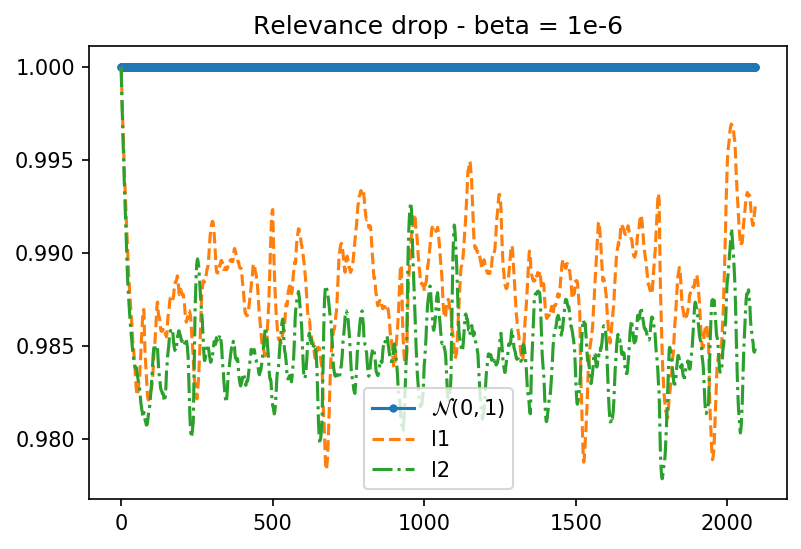

In [125]:
fig = plt.figure('Relevance')
fig.set_dpi(150)
ax = plt.gca()
ax.set_title('Relevance drop - beta = 1e-6')
plt.plot(hR1.R[0], '.-',label='$\mathcal{N}(0,1)$')
plt.plot(hR1.R[1], '--',label='l1')
plt.plot(hR1.R[2], '-.',label='l2')
plt.legend()